# Calculate SR1.5 CO$_2$ AFOLU emissions without model reported sinks

1. we use scenario from the [SR1.5 scenario explorer](data.ene.iiasa.ac.at/iamc-1.5c-explorer)
1. we calculate AFOLU CO$_2$ emissions without model reported sinks as the difference between CO$_2$ AFOLU emissions and carbon sequestration
1. we create some scenarios where we drop from the baseline scenario to zero over 10 years, starting at different points in time

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import os.path

import dotenv
import matplotlib.pyplot as plt
import scmdata

import utils

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
dotenv.load_dotenv()

True

<IPython.core.display.Javascript object>

In [4]:
plt.rcParams["figure.figsize"] = (12, 8)

<IPython.core.display.Javascript object>

## Paths

In [5]:
SR15_EXPLORER_DATA_CSV = os.path.join(
    utils.DATA_DIR,
    "raw",
    "sr15-scenarios",
    "sr15-scenario-explorer-output.csv",
)
SR15_EXPLORER_DATA_CSV

'/data2/ubuntu-znicholls/one-earth-2022/notebooks/../data/raw/sr15-scenarios/sr15-scenario-explorer-output.csv'

<IPython.core.display.Javascript object>

In [6]:
OUTPUT_FILE = os.path.join(
    utils.DATA_DIR,
    "interim",
    "afolu-no-model-reported-sinks",
    "co2-afolu-no-model-reported-sinks-emissions-from-sr15_{}.nc".format(
        utils.SCENARIO_CREATION_ID
    ),
)
os.makedirs(os.path.dirname(OUTPUT_FILE), exist_ok=True)
OUTPUT_FILE

'/data2/ubuntu-znicholls/one-earth-2022/notebooks/../data/interim/afolu-no-model-reported-sinks/co2-afolu-no-model-reported-sinks-emissions-from-sr15_7d7c42.nc'

<IPython.core.display.Javascript object>

## Load data

In [7]:
if not os.path.isfile(SR15_EXPLORER_DATA_CSV):
    utils.download_sr15_scenario_explorer_output(
        os.path.dirname(SR15_EXPLORER_DATA_CSV),
        out_name=os.path.basename(SR15_EXPLORER_DATA_CSV),
    )

<IPython.core.display.Javascript object>

In [8]:
sr15_explorer_data = scmdata.ScmRun(SR15_EXPLORER_DATA_CSV, lowercase_cols=True)
sr15_explorer_data = sr15_explorer_data.resample("AS")
sr15_explorer_data

<ScmRun (timeseries: 1069, timepoints: 101)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	                category              model region                scenario  \
	0     1.5C low overshoot        AIM/CGE 2.0  World  ADVANCE_2020_1.5C-2100   
	1     1.5C low overshoot        AIM/CGE 2.0  World  ADVANCE_2020_1.5C-2100   
	2              Higher 2C        AIM/CGE 2.0  World      ADVANCE_2020_Med2C   
	3              Higher 2C        AIM/CGE 2.0  World      ADVANCE_2020_Med2C   
	4               Lower 2C        AIM/CGE 2.0  World       ADVANCE_2020_WB2C   
	...                  ...                ...    ...                     ...   
	1064            Above 2C  WITCH-GLOBIOM 4.4  World            CD-LINKS_NPi   
	1065  1.5C low overshoot  WITCH-GLOBIOM 4.4  World   CD-LINKS_NPi2020_1000   
	1066            Lower 2C  WITCH-GLOBIOM 4.4  World   CD-LINKS_NPi2020_1600   
	1067          Below 1.5C  WITCH-GLOBIOM 4.4  World    CD-LINKS_NPi2020_400   
	1068            Abo

<IPython.core.display.Javascript object>

In [9]:
sr15_explorer_data.get_unique_meta("model")

['AIM/CGE 2.0',
 'AIM/CGE 2.1',
 'C-ROADS-5.005',
 'GCAM 4.2',
 'IEA World Energy Model 2017',
 'IMAGE 3.0.1',
 'IMAGE 3.0.2',
 'MERGE-ETL 6.0',
 'MESSAGE V.3',
 'MESSAGE-GLOBIOM 1.0',
 'MESSAGEix-GLOBIOM 1.0',
 'POLES ADVANCE',
 'POLES CD-LINKS',
 'POLES EMF33',
 'REMIND 1.5',
 'REMIND 1.7',
 'REMIND-MAgPIE 1.5',
 'REMIND-MAgPIE 1.7-3.0',
 'Reference',
 'WITCH-GLOBIOM 3.1',
 'WITCH-GLOBIOM 4.2',
 'WITCH-GLOBIOM 4.4']

<IPython.core.display.Javascript object>

## Select scenarios and calculate approximate gross CO$_2$ AFOLU emissions

In [10]:
calculate_scenarios = sr15_explorer_data.filter(
    model=["AIM*", "GCAM*", "IEA*", "MERGE*", "REMIND*", "WITCH*"], keep=False
).filter(scenario="SSP*")

<IPython.core.display.Javascript object>

### Quick examination of impact of harmonisation on pathways

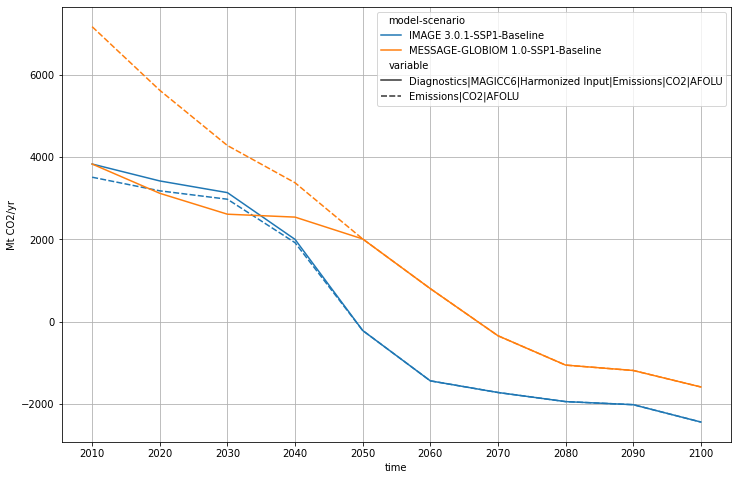

<IPython.core.display.Javascript object>

In [11]:
pdf = calculate_scenarios.filter(
    variable="*Emissions|CO2|AFOLU",
    scenario="SSP1-Baseline",
    year=range(2010, 2100 + 1),
)
pdf["model-scenario"] = pdf["model"] + "-" + pdf["scenario"]
ax = pdf.lineplot(hue="model-scenario", style="variable", time_axis="year")
ax.set_xticks(range(2010, 2100 + 1, 10))
ax.grid()

### Calculate gross CO$_2$ emissions

In [12]:
gross_co2_emissions = calculate_scenarios.filter(variable="Emissions|CO2|AFOLU").add(
    calculate_scenarios.filter(variable="Carbon Sequestration|Land Use"),
    op_cols={"variable": "Emissions|CO2|AFOLU|No model reported sinks"},
)

<IPython.core.display.Javascript object>

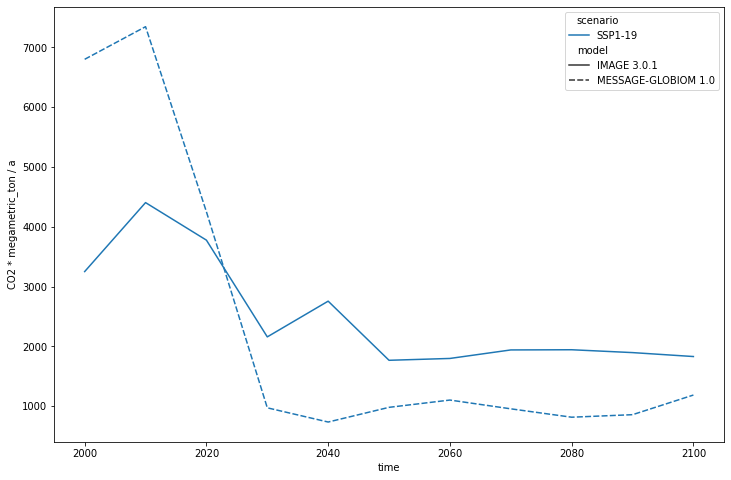

<IPython.core.display.Javascript object>

In [13]:
gross_co2_emissions.filter(scenario="SSP1-19").lineplot(style="model")

(-6.0, 8.0)

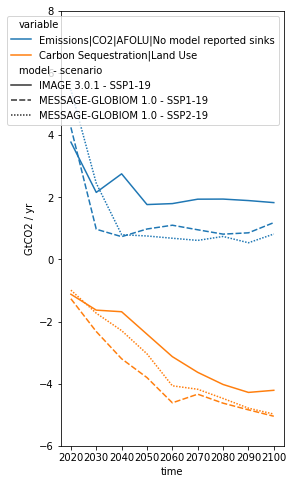

<IPython.core.display.Javascript object>

In [14]:
pdf = (
    (gross_co2_emissions)
    .append(-1 * calculate_scenarios.filter(variable="*Land Use"))
    .filter(scenario="*19", year=range(2020, 3000))
)
pdf["model - scenario"] = pdf["model"] + " - " + pdf["scenario"]
fig, ax = plt.subplots(figsize=(4, 8))
ax = pdf.convert_unit("GtCO2 / yr").lineplot(
    hue="variable", style="model - scenario", ax=ax
)
ax.set_ylim([-6, 8])

Roe et al. 2019 Figure 2b. It's not perfect but I can convince myself that the MESSAGE SSP2-19 lines look similar enough for our method to be defensible.

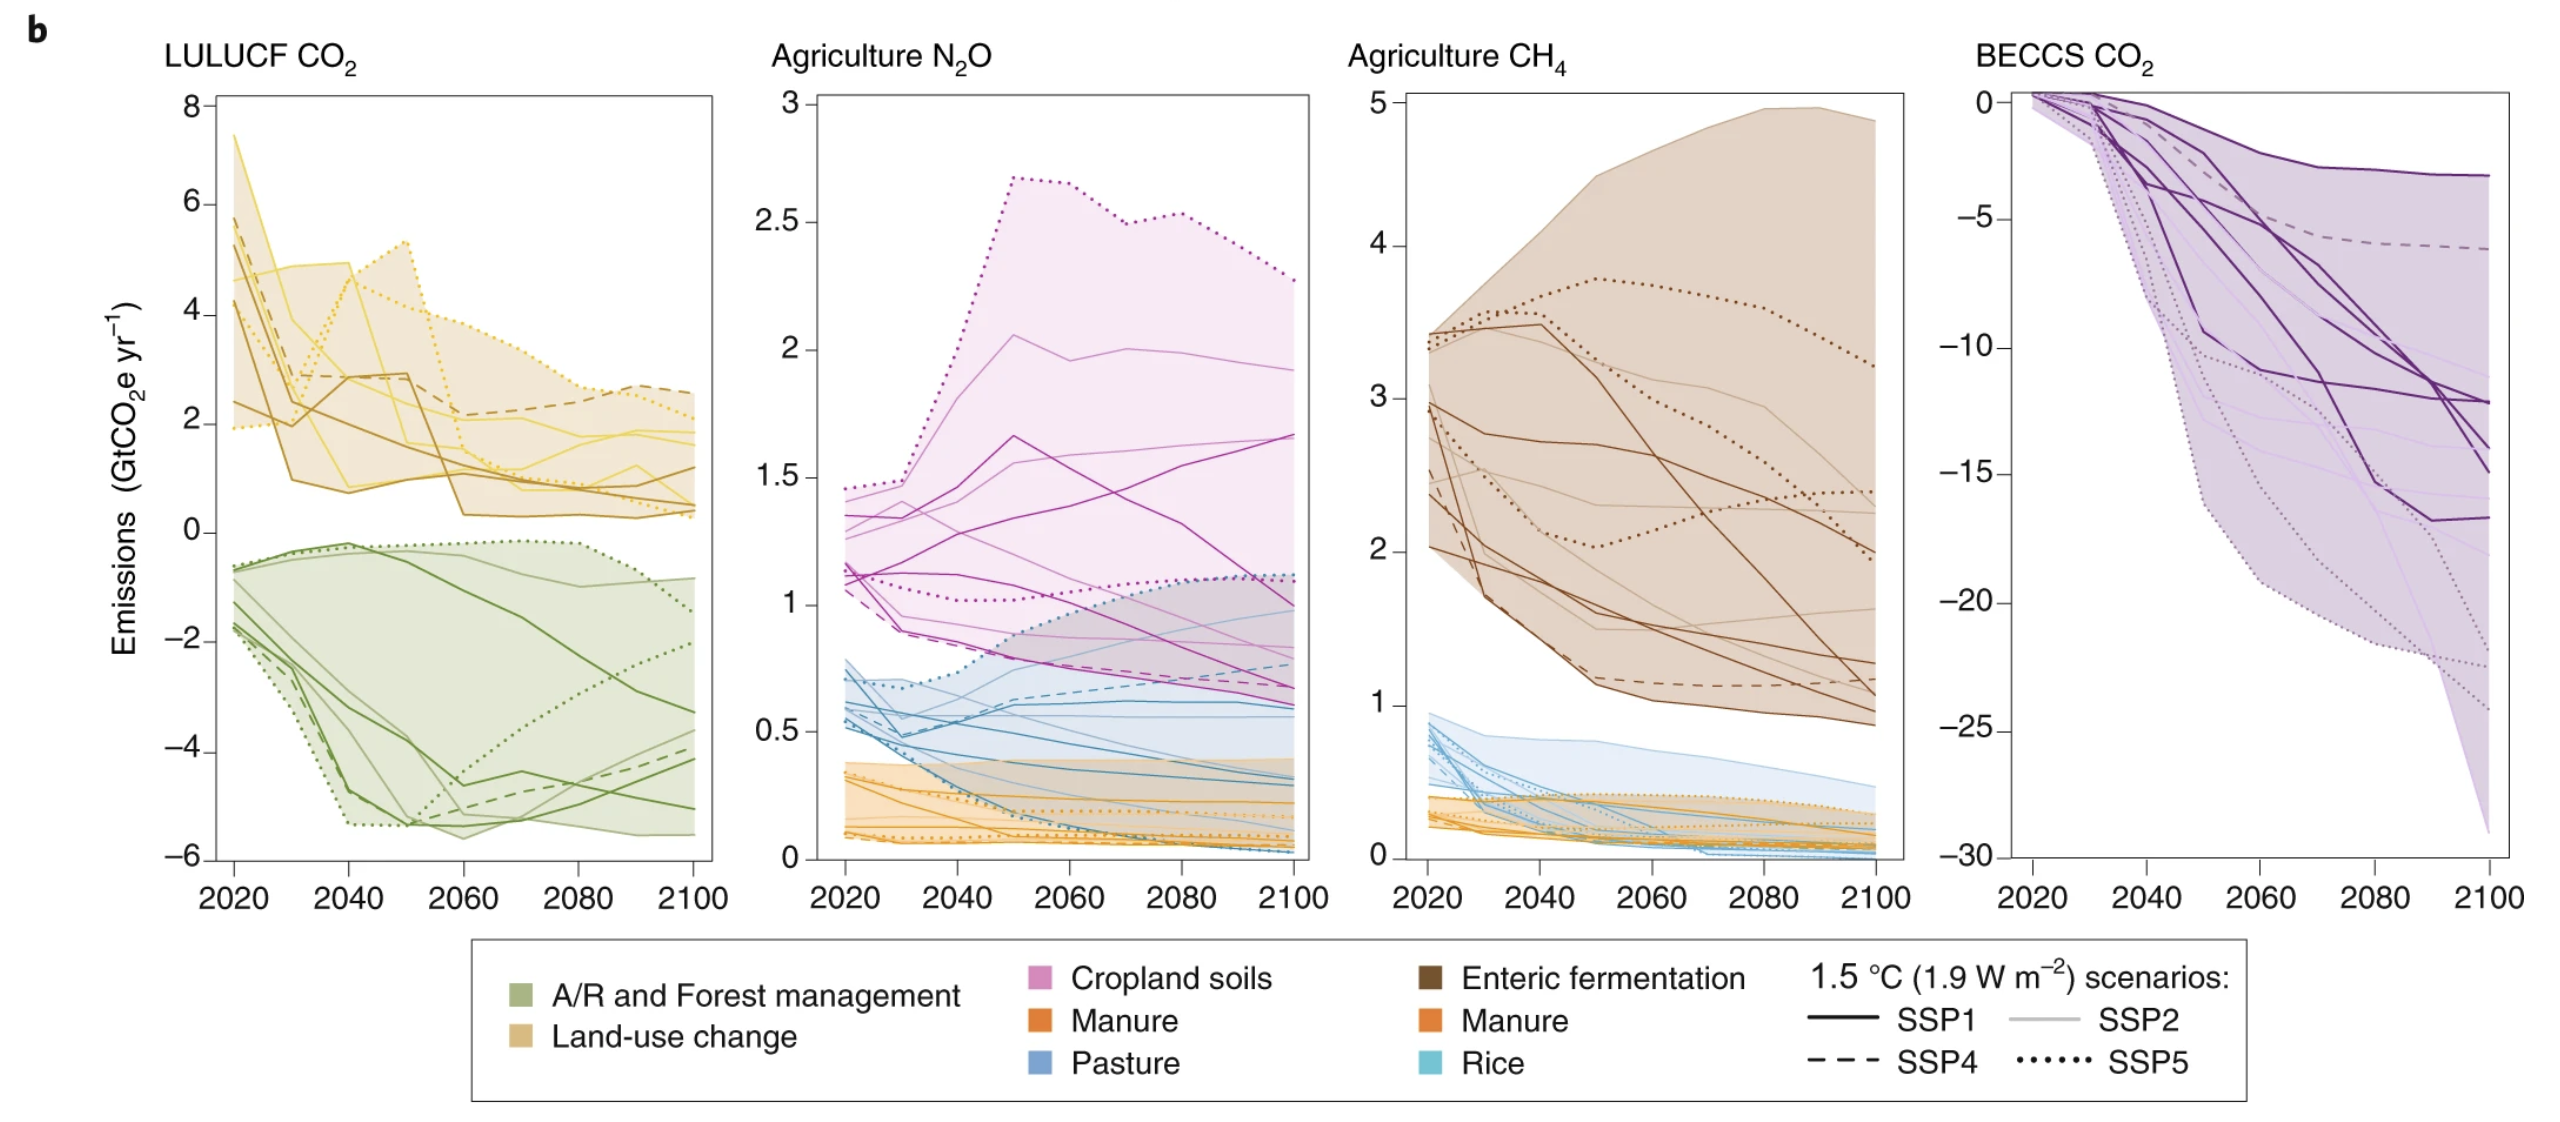

In [15]:
reduction_years = 10

tmp_all = []
for end_deforest_year in [2030, 2035, 2040, 2050]:
    tmp = gross_co2_emissions.filter(
        scenario="SSP1-Baseline",
        model="IMAGE*",
        year=range(1, end_deforest_year - reduction_years + 1),
    ).timeseries(time_axis="year")
    tmp.loc[:, end_deforest_year] = 0
    tmp.loc[:, 2100] = 0
    tmp = scmdata.ScmRun(tmp)
    tmp["scenario"] = "End deforestation {}".format(end_deforest_year)
    tmp["model"] = "Idealised from {}".format(tmp.get_unique_meta("model", True))
    tmp_all.append(tmp)

tmp_all = scmdata.run_append(tmp_all).resample("AS")
tmp_all

<ScmRun (timeseries: 4, timepoints: 101)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	   category                       model region                scenario  \
	0  Above 2C  Idealised from IMAGE 3.0.1  World  End deforestation 2030   
	1  Above 2C  Idealised from IMAGE 3.0.1  World  End deforestation 2035   
	2  Above 2C  Idealised from IMAGE 3.0.1  World  End deforestation 2040   
	3  Above 2C  Idealised from IMAGE 3.0.1  World  End deforestation 2050   
	
	                       unit                                     variable  \
	0  CO2 * megametric_ton / a  Emissions|CO2|AFOLU|No model reported sinks   
	1  CO2 * megametric_ton / a  Emissions|CO2|AFOLU|No model reported sinks   
	2  CO2 * megametric_ton / a  Emissions|CO2|AFOLU|No model reported sinks   
	3  CO2 * megametric_ton / a  Emissions|CO2|AFOLU|No model reported sinks   
	
	   version  
	0        1  
	1        1  
	2        1  
	3        1  

<IPython.core.display.Javascript object>

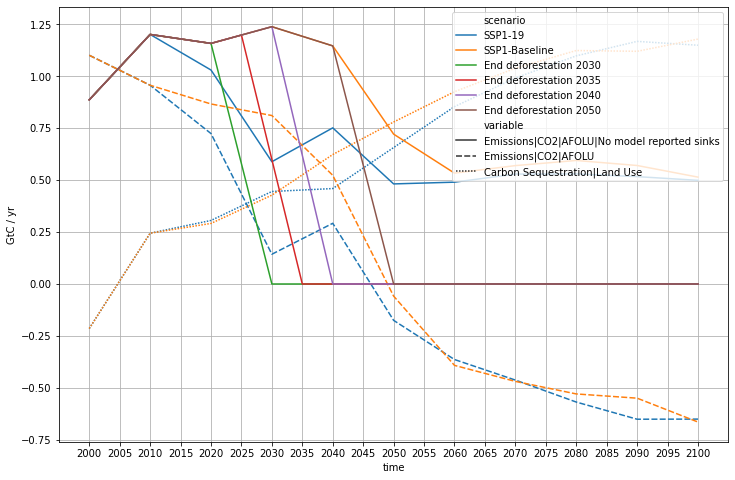

<IPython.core.display.Javascript object>

In [16]:
full_dataset = calculate_scenarios.append(gross_co2_emissions).append(tmp_all)
full_dataset["scenario"] = full_dataset["scenario"].apply(str)

ax = (
    full_dataset.filter(
        scenario=["SSP1-Baseline", "SSP1-19", "End*"],
        model=["IMAGE*", "Idealised*"],
        #         scenario=["SSP*-Baseline", "SSP1-19", "End*"],
        #         scenario=["SSP1-Baseline"],
        #         model=["IMAGE*", "Idealised*"],
    )
    #         full_dataset.filter(scenario=["SSP1-Baseline", "SSP1-19"], model="MESSAGE*")
    .filter(variable=["*model*", "Em*AFOLU", "Carbon*"]).convert_unit("GtC / yr")
    #     .resample("AS")
    #     .integrate()
    .lineplot(style="variable", time_axis="year")
)
ax.set_xticks(range(2000, 2100 + 1, 5))
ax.legend(loc="upper right")
ax.grid()

In [17]:
full_dataset

<ScmRun (timeseries: 171, timepoints: 101)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	               category                       model region  \
	0    1.5C low overshoot                 IMAGE 3.0.1  World   
	1    1.5C low overshoot                 IMAGE 3.0.1  World   
	2              Lower 2C                 IMAGE 3.0.1  World   
	3              Lower 2C                 IMAGE 3.0.1  World   
	4              Above 2C                 IMAGE 3.0.1  World   
	..                  ...                         ...    ...   
	166            Above 2C         MESSAGE-GLOBIOM 1.0  World   
	167            Above 2C  Idealised from IMAGE 3.0.1  World   
	168            Above 2C  Idealised from IMAGE 3.0.1  World   
	169            Above 2C  Idealised from IMAGE 3.0.1  World   
	170            Above 2C  Idealised from IMAGE 3.0.1  World   
	
	                   scenario                      unit  \
	0                   SSP1-19                 Mt CO2/yr   
	1              

<IPython.core.display.Javascript object>

In [18]:
full_dataset.filter(variable="*No model reported sinks").drop_meta(
    ["version", "category"]
).to_nc(OUTPUT_FILE, dimensions=("scenario",), extras=("model",))

<IPython.core.display.Javascript object>